## Importing the neccessary libraries

In [1]:
from tqdm import tqdm
from helper import *

2023-11-23 19:22:39.345590: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 19:22:39.518336: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 19:22:39.519828: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-23 19:22:40.436922: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## loading our style and content image

In [16]:
#content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
#style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
content_path = "content2.jpeg"
style_path = "art2.jpg"

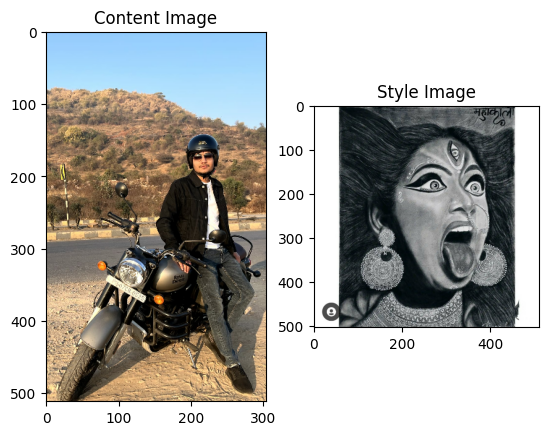

In [17]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [18]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
  print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


## defining neural architectures for our style and content extracto models

In [19]:
class StyleModel(tf.keras.models.Model):
    def __init__(self):
        super(StyleModel, self).__init__()
        self.layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1',  'block4_conv1',  'block5_conv1']
        self.model = tf.keras.Model(inputs=[vgg.input], outputs=[vgg.get_layer(name).output for name in self.layer_names])
        self.model.trainable = False
    
    def __call__ (self, inputs):
        inputs = inputs*255.0
        preprocessed_inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.model(preprocessed_inputs)
        outputs = [self.gram_matrix(output) for output in outputs]
        ret = {layer:output for layer, output in zip(self.layer_names, outputs)}
        return ret
    
    @staticmethod
    def gram_matrix(input_tensor):
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
        return result/(num_locations)

In [20]:
class ContentModel(tf.keras.models.Model):
    def __init__(self):
        super(ContentModel, self).__init__()
        self.layer_names = ['block5_conv2'] 
        self.model = tf.keras.Model(inputs=[vgg.input], outputs=[vgg.get_layer(name).output for name in self.layer_names])
        self.model.trainable = False
    
    def __call__(self, inputs):
        inputs = inputs*255.0
        preprocessed_inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.model(preprocessed_inputs)
        ret = {layer:output for layer, output in zip(self.layer_names, outputs)}
        return ret

## defining hyperparameters

In [21]:
epochs = 10
steps_per_epochs = 10
style_weight=1e-2
content_weight=1e4
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

## Stylizing the content image using gradient descent 

In [22]:
#@tf.function()
def train_step(image, style_model, content_model, style_targets, content_targets):
    with tf.GradientTape() as tape:
        style_outputs = style_model(image)
        content_outputs = content_model(image)
        loss = style_content_loss(style_outputs, content_outputs, style_targets, content_targets, style_weight, content_weight)
    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [23]:
style_model = StyleModel()
content_model = ContentModel()
image = tf.Variable(content_image)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_targets = style_model(style_image)
content_targets = content_model(content_image)

for epoch in tqdm(range(epochs)):
    for m in range(steps_per_epochs):
        train_step(image, style_model, content_model, style_targets, content_targets)

100%|██████████| 10/10 [07:35<00:00, 45.58s/it]


## final output

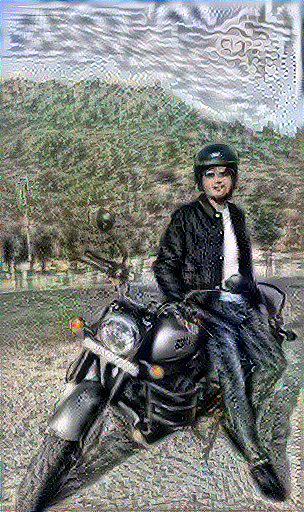

In [24]:
tensor_to_image(image)